In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import gensim
from gensim.models import CoherenceModel
from gensim import corpora
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics import pairwise_distances

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
def find_optimize_components(corpus, data_tokens, id2word, lst_components):
    lst_coherence = []
    optimize_components = 2
    optimize_coherence_lda = -10000
    for num_topics in lst_components:
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
        #coherence_model_lda_umass = CoherenceModel(model=lda_model, texts=data_tokens, dictionary=id2word, coherence='u_mass')
        coherence_model_lda_cv = CoherenceModel(model=lda_model, texts=data_tokens, dictionary=id2word, coherence='c_v')

        #coherence_lda_umass = coherence_model_lda_umass.get_coherence()
        coherence_lda_cv = coherence_model_lda_cv.get_coherence()
        
        coherence_lda = coherence_lda_cv#*coherence_lda_umass
        if coherence_lda > optimize_coherence_lda:
            optimize_coherence_lda = coherence_lda
            optimize_components = num_topics
            optimize_lda_model = lda_model
        lst_coherence.append(coherence_lda)
        
    plt.plot(lst_components, lst_coherence)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
    print('optimize count of topics:', optimize_components)
    print('optimize_coherence_score:', optimize_coherence_lda)
    print('\n')
    
    return optimize_components, optimize_lda_model

In [3]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: x[1], reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [4]:
def lda_research(data, optimize_components=2):
    
    print('count texts:', len(data))
    
    all_words = ' '.join([word for word in data])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
    plt.figure(figsize=(7, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()


    data_tokens = np.array(data.apply(lambda x: x.split()))
    id2word = corpora.Dictionary(data_tokens)
    corpus = [id2word.doc2bow(text) for text in data_tokens]
    if optimize_components <=2:
        optimize_components, lda_model = find_optimize_components(corpus, data_tokens, id2word, 
                                                                  lst_components=list(range(20))[2:])
    else:    
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=optimize_components, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    for topic in lda_model.print_topics():
        topic_keywords = re.sub(r'[\d*"".]', '', topic[1])
        print(topic[0], topic_keywords)

        
    df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=np.array(data))

    df_dominant_topic = df_topic_sents_keywords.reset_index().dropna().sort_values(by = 'Dominant_Topic')
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'clean_text']
    df_dominant_topic = df_dominant_topic.sort_values(by = ['Dominant_Topic', 'Topic_Perc_Contrib'], ascending=False)
    df_dominant_topic['title'] = df_dominant_topic['clean_text'].map(dict_clean_text)
    dict_topics = {t:i for i, t in enumerate(set(df_dominant_topic['Dominant_Topic']))}
    df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].map(dict_topics)
    
    df_dominant_topic['Dominant_Topic'].hist(bins = 30)
    plt.show()

    
    return df_dominant_topic, lda_model, corpus, id2word

In [5]:
df = pd.read_csv('VKR_docs_for_analysing.csv')
df = df[['path_doc', 'title', 'dict_paragraphs_text', 'all_text', 'analysing_text']]
df['dict_paragraphs_text'] = df['dict_paragraphs_text'].map(eval)
df['analysing_text'] = df['analysing_text'].map(eval)
print('Количество текстов:', len(df))
df.head()

Количество текстов: 358


,path_doc,title,dict_paragraphs_text,all_text,analysing_text
0,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Анализ методов обеспечения безопасной передачи...,"{0: 'ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА.', 1: '...",ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА. АНАЛИЗ МЕТО...,"[выпускной квалификационный работа, анализ мет..."
1,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Анализ психологических типов сотрудников для м...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,[министерство наука высокий образование россий...
2,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Исследование влияния алгоритма стохастического...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,[министерство наука высокий образование россий...
3,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Разработка VPN-приложения для мобильных устрой...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,[министерство наука высокий образование россий...
4,C:/Users/JM 505 Computers/Desktop/Repetitor/Ул...,Разработка автоматизированной системы защиты и...,{0: 'Министерство науки и высшего образования ...,Министерство науки и высшего образования Росси...,[министерство наука высокий образование россий...


In [8]:
df['clean_text'] = df['analysing_text'].apply(lambda x: ' '.join(x))

df_dict_clean_text = df[['title', 'clean_text']]
df_dict_clean_text.index = df['clean_text']
dict_clean_text = dict(df_dict_clean_text['title'])

count texts: 358


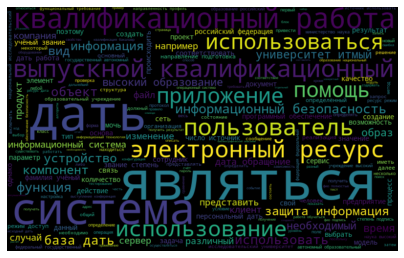

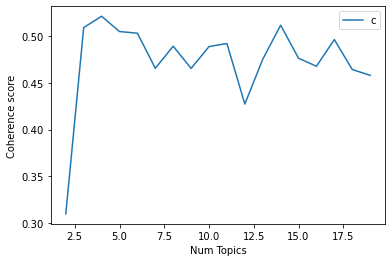

optimize count of topics: 4
optimize_coherence_score: 0.5211985482735355


0 система + информация + дать + безопасность + защита + информационный + сеть + доступ + работа + угроза
1 продукт + производство + вода + молоко + температура + напиток + работа + вещество + пищевой + сырьё
2 дать + работа + приложение + система + пользователь + компонент + запрос + метод + класс + файл
3 система + работа + требование + процесс + дать + документ + клиент + заявка + должный + пользователь


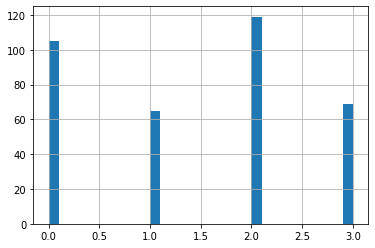

Wall time: 40min 26s


In [9]:
%%time
df_topics, lda_model, corpus, id2word = lda_research(data = df['clean_text'], optimize_components=2)

In [10]:
df_topics

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,clean_text,title
285,285,3,0.9991,"система, работа, требование, процесс, дать, до...",министерство наука высокий образование российс...,Разработка конфигурации на платформе 1С Предпр...
279,279,3,0.9989,"система, работа, требование, процесс, дать, до...",министерство наука высокий образование российс...,Разработка конфигурации на платформе 1С Предпр...
353,353,3,0.9987,"система, работа, требование, процесс, дать, до...",министерство наука высокий образование российс...,Формирование требований к модулю учёта расходо...
342,342,3,0.9987,"система, работа, требование, процесс, дать, до...",министерство наука высокий образование российс...,Формирование требований для автоматизированной...
352,352,3,0.9983,"система, работа, требование, процесс, дать, до...",министерство наука высокий образование российс...,Формирование требований к модулю управления пл...
...,...,...,...,...,...,...
26,26,0,0.5638,"система, информация, дать, безопасность, защит...",выпускной квалификационный работа разработка п...,Разработка и программная реализация метода защ...
39,39,0,0.5538,"система, информация, дать, безопасность, защит...",выпускной квалификационный работа разработка м...,Разработка метода анализа окружающей среды в у...
50,50,0,0.5432,"система, информация, дать, безопасность, защит...",министерство наука высокий образование российс...,Разработка методики защиты приложений от ревер...
11,11,0,0.5312,"система, информация, дать, безопасность, защит...",министерство наука высокий образование российс...,Разработка алгоритма классификации электронной...


#### Визуализация

0


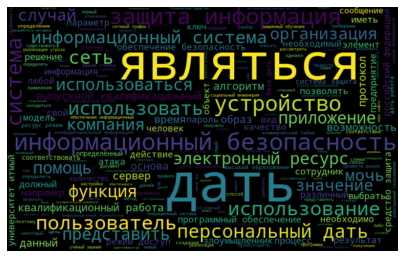



1


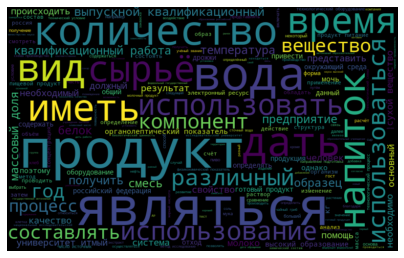



2


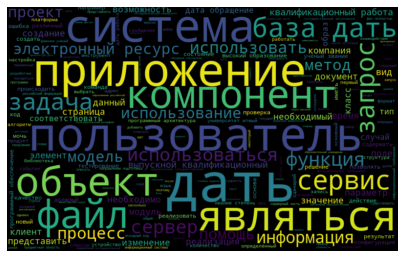



3


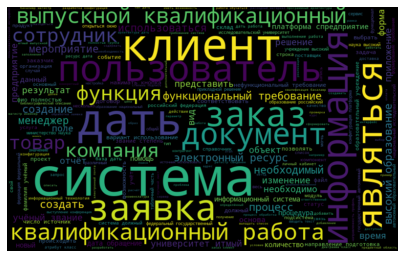

In [11]:
for topic in set(df_topics.Dominant_Topic):
    print(topic)
    data = df_topics[df_topics.Dominant_Topic == topic]['clean_text']
    all_words = ' '.join([word for word in data])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
    plt.figure(figsize=(7, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    print('\n')

In [12]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.106206  0.005162       1        1  30.282264
0     -0.000966 -0.144739       2        1  30.184075
1     -0.218863  0.049768       3        1  23.959373
3      0.113623  0.089808       4        1  15.574289, topic_info=              Term          Freq         Total Category  logprob  loglift
30    безопасность   5076.000000   5076.000000  Default  30.0000  30.0000
216         защита   4975.000000   4975.000000  Default  29.0000  29.0000
862        система  15234.000000  15234.000000  Default  28.0000  28.0000
255     информация   9291.000000   9291.000000  Default  27.0000  27.0000
707     приложение   4890.000000   4890.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
255     информация   1271.663848   9291.454975   Topic4  -5.1955  -0.1292
3093        модуль    865.541179   2644.216379   Topic4  -5.5802   0.7428
460          новый    859.749214   2722.080965   Topic4  -5.5869   0.7070
76     возможность    801.331404   3421.129802   Topic4  -5.6573   0.4081
2274         класс    793.436015   3374.381147   Topic4  -5.6672   0.4120

[345 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
37050      1  0.996921         абтест
1          1  0.363700  автоматизация
1          2  0.001800  автоматизация
1          3  0.015304  автоматизация
1          4  0.620271  автоматизация
...      ...       ...            ...
1111       4  0.117783       являться
1112       1  0.934064           язык
1112       2  0.000874           язык
1112       3  0.007864           язык
1112       4  0.056795           язык

[712 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

In [13]:
df_topics.to_csv('df_topics.csv', index=False)